In [1]:
# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import FISTA, HybridGLSQR, GLSQR
from cil.optimisation.utilities.HybridUpdateReg import UpdateRegDiscrep, UpdateRegGCV, UpdateRegLcurve, UpdateRegReginska, UpdateRegUPRE
from cil.optimisation.functions import L1Norm,  LeastSquares
from cil.optimisation.operators import GradientOperator

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# CIL data structures and utilities
from cil.utilities.display import show2D

# Third-party imports
import numpy as np    

## Load Data
In this example, we utilize CIL's simulated sphere data. To accelerate computations in this notebook, we extract a 2D slice from the 3D dataset. Additionally, we select a subset of angles to create a limited-angle reconstruction scenario. We will then compare the ground truth data with a filtered back projection (FBP) reconstruction under these limited-angle conditions.

New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.]
	Rotation axis position: [0., 0.]
	Detector position: [    0., 60000.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [128   1]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128)
New geometry shape:  (60, 128)
FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



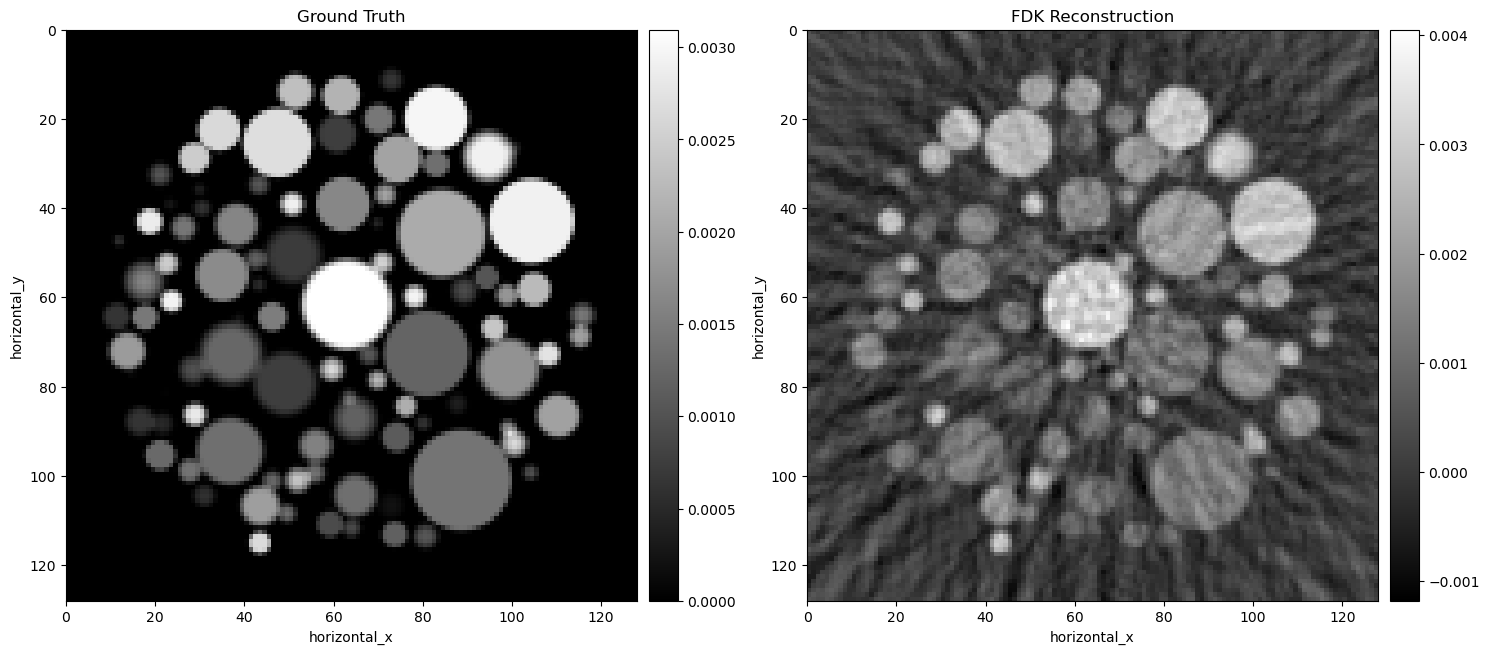

In [2]:
from data_loader import load_and_process_sphere

# Load data
data, A, ig, ground_truth, recon = load_and_process_sphere(angle_step=5)

# Set up Initial
initial = A.domain_geometry().allocate(0)


## Hybrid methods in action L1 Regularization

In [3]:
# We set a tolerance, an initial guess, and a maximum number of iterations
alpha_tol = 1e-10
maxit = 100

# Define noise level
noise_std = 0.1 * np.std(data.array) 
noiselevel = 0.1 * np.linalg.norm(data.array)
noisevariance = noise_std**2

# Flag to reinitialize GKB at each outer iteration
reinitialize_GKB = True

G = GradientOperator(
    ig,
    method='forward',            # required for C backend
    bnd_cond='Neumann',           # or 'Periodic'
    correlation='Space',          # gradient only in spatial dimensions
    backend='c'                   # will fall back to numpy if needed
)

## L-curve rule on standard Tikhonov

In [4]:
""" lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                         reg_norm_type='L2', hybrid_reg_rule=lcurve_rule)

hybridlsqrlcurve.run(maxit, verbose=True) """

" lcurve_rule = UpdateRegLcurve(data_size=data.size,\n                                domain_size=initial.size, \n                                tol=alpha_tol)\n\nhybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,\n                         reg_norm_type='L2', hybrid_reg_rule=lcurve_rule)\n\nhybridlsqrlcurve.run(maxit, verbose=True) "

In [5]:
""" print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-8, 1e2))
hybridlsqrlcurve.reg_rule.plot_history()

show2D([ground_truth, hybridlsqrlcurve.solution], title = ['Ground Truth', f"L-Curve \n Optimal alpha: {hybridlsqrlcurve.regalpha:.2e}"], origin = 'upper', num_cols = 2) """

' print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")\n\nhybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-8, 1e2))\nhybridlsqrlcurve.reg_rule.plot_history()\n\nshow2D([ground_truth, hybridlsqrlcurve.solution], title = [\'Ground Truth\', f"L-Curve \n Optimal alpha: {hybridlsqrlcurve.regalpha:.2e}"], origin = \'upper\', num_cols = 2) '

## L-curve rule on Tikhonov on the gradient

In [6]:
lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                               struct_operator = G,
                         reg_norm_type='L2', hybrid_reg_rule=lcurve_rule)

hybridlsqrlcurve.run(maxit, verbose=True)


c:\Users\P285563\AppData\Local\miniconda3\envs\cil_dev\Lib\site-packages\cil\framework\data_container.py:112: UserWarning: Over-riding geometry.dtype with data.dtype
  warnings.warn("Over-riding geometry.dtype with data.dtype", UserWarning)


  0%|          | 0/100 [00:00<?, ?it/s]

The optimal parameter it finds is 38345.37298939044 in 33 iterations


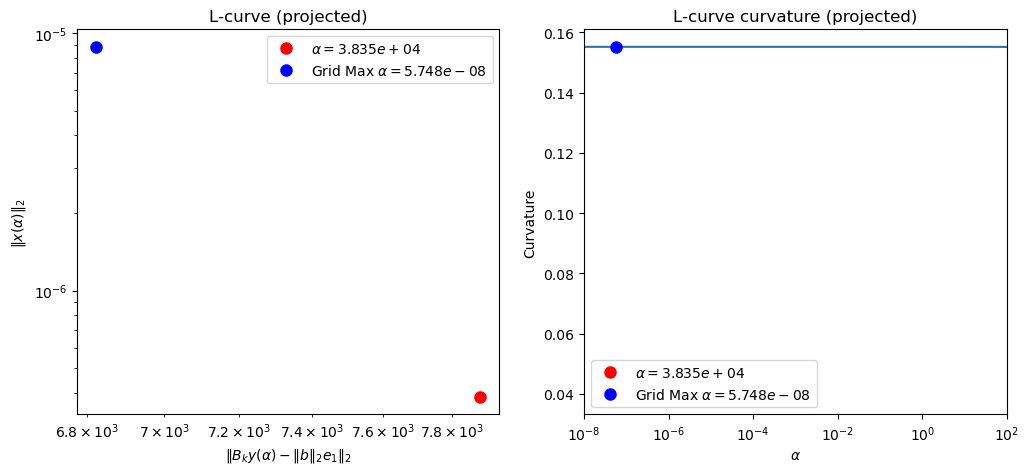

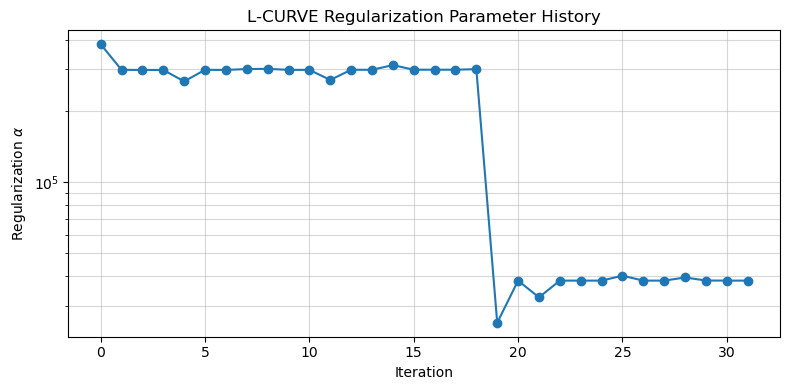

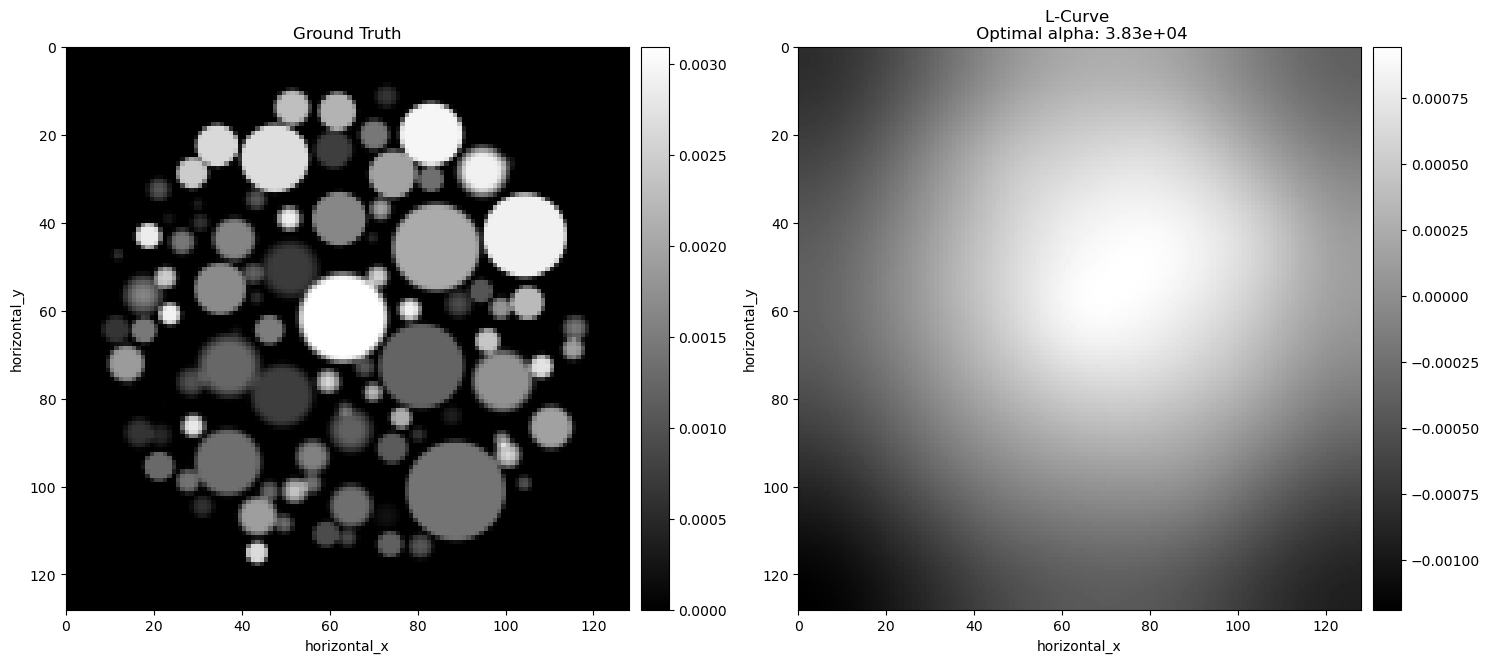

In [7]:
print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-8, 1e2))
hybridlsqrlcurve.reg_rule.plot_history()

show2D([ground_truth, hybridlsqrlcurve.solution], title = ['Ground Truth', f"L-Curve \n Optimal alpha: {hybridlsqrlcurve.regalpha:.2e}"], origin = 'upper', num_cols = 2)